In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import sleep
from pylab import rcParams

%matplotlib inline
%load_ext autoreload
%autoreload 2

rcParams['figure.figsize'] = 10, 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from env.env_2players_naive_torus import NaiveSandbox

In [20]:
from loss.losses import sum_loss_l1
from model.a2c import *

In [21]:
def probs_to_cells(probs, env, topk=3, player=1):
    probs_top_k, idx_top_k = probs.topk(topk)
    inserted_block = np.zeros(env.shape)
    inserted_block = inserted_block.flatten()
    inserted_block[idx_top_k] = player
    return inserted_block.reshape(env.shape)

In [22]:
def render(perception_field, env_state, render_agent=False):
    clear_output(wait=True)
    if render_agent:
        plt.imshow(perception_field)
        plt.show()
    #print('field after agent inference')
    plt.imshow(env_state['grid'])
    plt.show()

In [23]:
import torch
import torch.optim as optim

In [24]:
from reward.rewards import AliveCellsReward, MultipleAgentsCellsReward
reward_fn = MultipleAgentsCellsReward()

In [25]:
def merge(old, new):
    if old == 0:
        return new
    return old
merge_perceptions = np.vectorize(merge)

In [26]:
def merge_agents(first_probs, first_values, second_probs, second_values):
    probs = [first_probs, second_probs]
    if first_values != second_values:
        if first_values == 0:
            return second_values
        if second_values == 0:
            return first_values
        #return probs.index(max(probs)) + 1
        return 0
    return first_values
merge_agents = np.vectorize(merge_agents)

In [35]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def flatten_grid(grid):
    return torch.tensor(grid).float().flatten().to(DEVICE)

def unsqueeze_grid(grid):
    return torch.FloatTensor(grid).unsqueeze(0).unsqueeze(0).to(DEVICE)

def unsqueeze_states(states):
    return torch.FloatTensor(states).view(-1, 10, 10).unsqueeze(1).to(DEVICE)

In [36]:
def step_agent(agent, agent_id=1):
    probs = agent.get_action_probs(flatten_grid(sandbox.get_grid()))
    perception_field = probs_to_cells(probs.detach(), sandbox.get_grid(), N_CELLS, player=agent_id)
    return perception_field, probs.view(sandbox.get_grid().shape).detach()

In [50]:
from time import sleep
def play_game(iterations, state, render_env=True, fall_asleep=False):
    for i in range(iterations):
        perception_1, probs_1 = step_agent(agent_1, 1)
        perception_2, probs_2 = step_agent(agent_2, 2)
        
        perception_field = merge_agents(probs_1, perception_1, probs_2, perception_2)
        perception_field = merge_perceptions(sandbox.get_grid(), perception_field)
        
        sandbox.insert_block(perception_field, 0, 0)
        for s in range(steps_after_action):
            if render_env:
                render(perception_1, {'grid':sandbox.get_grid()})
            if fall_asleep:
                sleep(1.5)
            sandbox.step()

            rewards = reward_fn(sandbox.get_grid())
            env_state = {"grid": sandbox.get_grid(), "rewards":  rewards, "done": sandbox.is_done()}

            if render_env:
                render(perception_1, env_state)
            next_state, reward, done = env_state['grid'], env_state['rewards'], env_state['done']

            states.append(state.flatten());dones.append(done);
            
            intristic_reward = rnd.get_intristic_reward(unsqueeze_grid(state))
            
            rewards1.append(intristic_reward.detach() + torch.tensor(reward[0]).to(DEVICE))
            rewards2.append(intristic_reward.detach() + torch.tensor(reward[1]).to(DEVICE))
            actions1.append(perception_1) 
            actions2.append(perception_2)
            

            state = next_state
            if fall_asleep: sleep(0.5)
        if fall_asleep:
            print ("Agents step NOW")
            sleep(0.5)
    print (np.mean(rewards1), np.mean(rewards2))

In [51]:
def reflect_agent(agent, optimizer, states, actions, rewards, dones, list_loss):
    
    intristic_reward = rnd.get_intristic_reward(unsqueeze_states(states))
    intristic_reward.backward()
    rnd_optimizer.step()
    
    total_loss = agent.reflect(states, actions, rewards, dones)
    if np.isnan(total_loss.item()):
        return
    optimizer.zero_grad()
    total_loss.backward()
    
    list_loss.append(total_loss.item())
    torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
    optimizer.step()

In [52]:
x0, y0 = 0, 0
iterations = 100
steps_after_action = 10
N_GAMES = 100
N_CELLS = 10
GRID = 10
LR = 0.001

grid_size=(GRID,GRID)
sandbox = NaiveSandbox(grid_size=grid_size)
state = sandbox.get_grid()

In [53]:
from reward.curiosity_reward import RNDModel

In [54]:
agent_1 = ActorCritic(GRID*GRID, GRID*GRID).to(DEVICE)
agent_2 = ActorCritic(GRID*GRID, GRID*GRID).to(DEVICE)


rnd = RNDModel(1, 1).to(DEVICE)
rnd_optimizer = optim.Adam(rnd.parameters())

optimizer_1 = optim.Adam(agent_1.parameters(), lr=LR)
optimizer_2 = optim.Adam(agent_2.parameters(), lr=LR)

In [ ]:
list_loss1, list_loss2 = [], []
reward_list1, reward_list2 = [], []
for game in range(N_GAMES):
    states, actions1, actions2, rewards1, rewards2, dones = [], [], [], [], [], []
    
    play_game(iterations, state, render_env=False)
    reflect_agent(agent_1, optimizer_1, states, actions1, rewards1, dones, list_loss1)
    reflect_agent(agent_2, optimizer_2, states, actions2, rewards2, dones, list_loss2)
    clear_output(wait=True)
    
    reward_list1.append(np.mean(rewards1))
    reward_list2.append(np.mean(rewards2))
    
    
    plt.subplot(2, 1, 1)
    plt.plot(list(range(len(list_loss1))), list_loss1)
    plt.plot(list(range(len(list_loss2))), list_loss2)
    
    plt.subplot(2, 1, 2)
    plt.plot(list(range(len(reward_list1))), reward_list1)
    plt.plot(list(range(len(reward_list2))), reward_list2)
    
    plt.show()

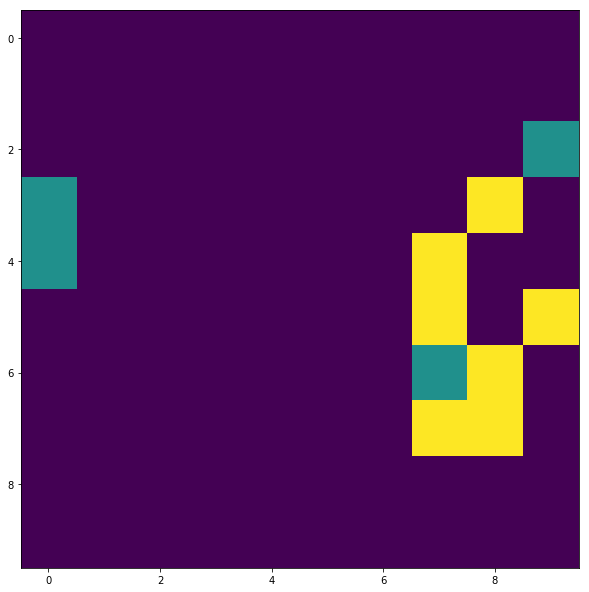

KeyboardInterrupt: 

In [49]:
grid_size=(GRID,GRID)
sandbox = NaiveSandbox(grid_size=grid_size)
state = sandbox.get_grid()
from time import sleep
steps_after_action = 10
states, actions, rewards, dones = [], [], [], []
play_game(30, state, fall_asleep=True)